# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
%matplotlib inline
from climada.hazard import TCTracks
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from itertools import product

In [42]:
from klearn_tcyclone.data_utils import standardize_time_series_list, concatenate_time_series_list

In [3]:
from kooplearn.data import TrajectoryContextDataset, TensorContextDataset

# Import dependencies

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ml_confs

In [4]:
from klearn_tcyclone.data_utils import data_array_list_from_TCTracks, context_dataset_from_TCTracks
from klearn_tcyclone.data_utils import data_array_list_from_TCTracks
from random import sample

from klearn_tcyclone.testing_utils import provide_TensorContextData

In [5]:
import ml_confs
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks

In [6]:
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.plot_utils import plot_feature, plot_features

In [7]:
from klearn_tcyclone.data_utils import linear_transform, standardize_TensorContextDataset, LinearScaler

### Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [8]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-09-21 12:52:47,673 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


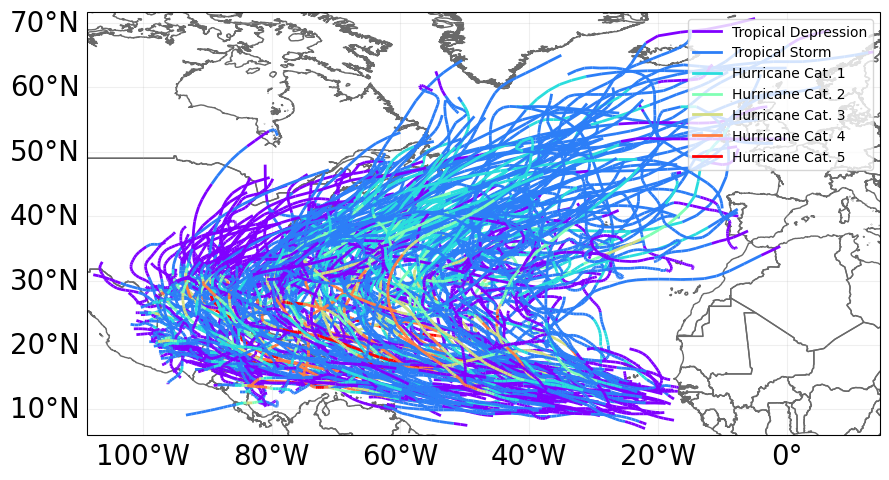

In [9]:
ax = tc_tracks.plot()

### Checking data quality

We plot variables along a few random tracks to get a better picture of how good the data is, i.e. if every feature/variable looks reasonable and that there are no large missing chunks of data.

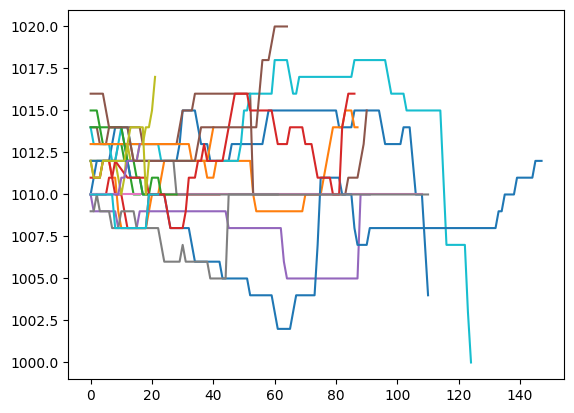

In [10]:
fig, ax = plt.subplots()
plot_feature(tc_tracks, "environmental_pressure", ax, n_tracks=20)

Data cleaning: In some cases some variables, e.g. the radius_max_wind, is constant for almost the full time track. These tracks might be affected by measurement errors or unavailable data. To remove these "corrupted" tracks could enhance model performance. For now, however, we leave all the tracks in the dataset.

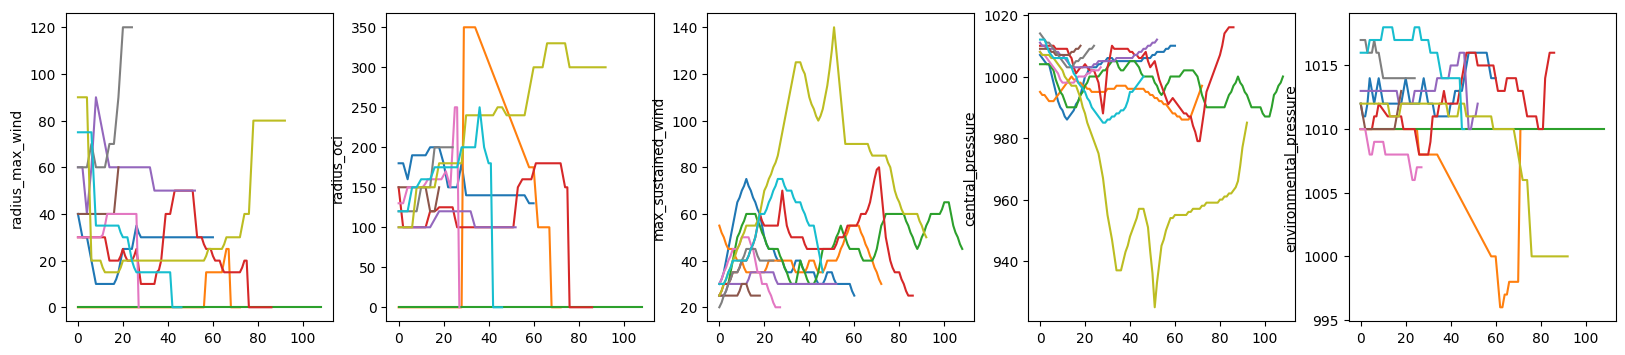

In [11]:
fig, ax = plt.subplots(1,5)
fig.set_size_inches(20,4)
features = [
    "radius_max_wind",
    "radius_oci",
    "max_sustained_wind",
    "central_pressure",
    "environmental_pressure",
]
plot_features(tc_tracks, features, ax, n_tracks=10)

### Data standardisation

An important pre-processing step is data standardisation. This step rescales the data to zero mean and unit variance, a regime where most of the common machine learning tools are targeted at. Also, data standardisation allows for better comparability between prediction performance on different datasets.

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = np.stack(
    [np.random.uniform(0,12,size=100), np.random.uniform(-12,3,size=100), np.random.uniform(2,6,size=100)],
    axis = 1
)

scaler = StandardScaler()

In [10]:
np.mean(data[:,0]), np.mean(data[:,1]), np.mean(data[:,2]), np.var(data[:,0]), np.var(data[:,1]), np.var(data[:,2])

(5.751358515417717,
 -4.106293947299778,
 3.967795511686654,
 9.603610506509304,
 16.866932253036367,
 1.3165621438784225)

In [11]:
_ = scaler.fit(data)
data_trafo = scaler.transform(data)

In [12]:
data_trafo.shape

(100, 3)

In [13]:
np.mean(data_trafo[:,0]), np.mean(data_trafo[:,1]), np.mean(data_trafo[:,2]), np.var(data_trafo[:,0]), np.var(data_trafo[:,1]), np.var(data_trafo[:,2])

(7.682743330406083e-16,
 5.559441795810472e-16,
 -1.4654943925052067e-16,
 1.0000000000000002,
 0.9999999999999999,
 1.0000000000000002)

Looks good.

Now we apply the data scaling to our TCTracks data.

In [14]:
# tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

# context_length = 42
# feature_list = ["lat", "lon"]
# time_lag = 1
# backend = "auto"

# data_array_list = data_array_list_from_TCTracks(
#     tc_tracks=tc_tracks, feature_list=feature_list
# )
# context_data_array = np.empty((0, context_length, len(feature_list)))
# for idx, data_array in enumerate(data_array_list):
#     if data_array.shape[0] >= context_length:
#         context_data_array = np.concatenate(
#             [
#                 context_data_array,
#                 TrajectoryContextDataset(
#                     data_array, context_length, time_lag, backend
#                 ).data,
#             ],
#             axis=0,
#         )

In [43]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

In [44]:
feature_list = ["lat", "lon"]
data_array_list = data_array_list_from_TCTracks(tc_tracks=tc_tracks_train, feature_list=feature_list)

In [45]:
scaler = LinearScaler()
rescaled_time_series_list = standardize_time_series_list(data_array_list, scaler=scaler, fit=True)

In [46]:
concate_ts = concatenate_time_series_list(rescaled_time_series_list)

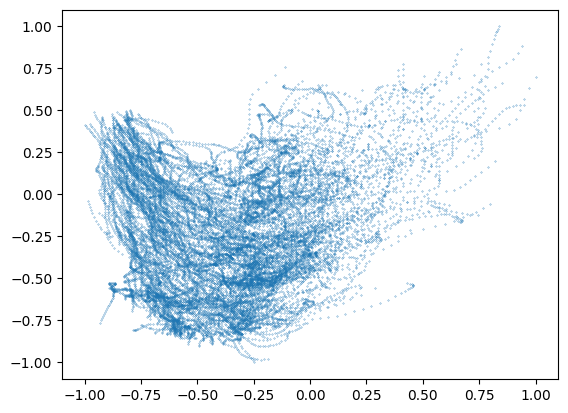

In [47]:
plt.plot(concate_ts[:,0], concate_ts[:,1], ".", linestyle='None', markersize=0.5)

In [ ]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [33]:
tensor_context = tensor_context_train
tensor_context_data_reshape = tensor_context.data.reshape((tensor_context.shape[0]*tensor_context.shape[1], tensor_context.shape[2]))

(326130, 2)

Testing the LinearScaler.

[70.69999695  6.5999999 ] [   7.         -107.69999695]


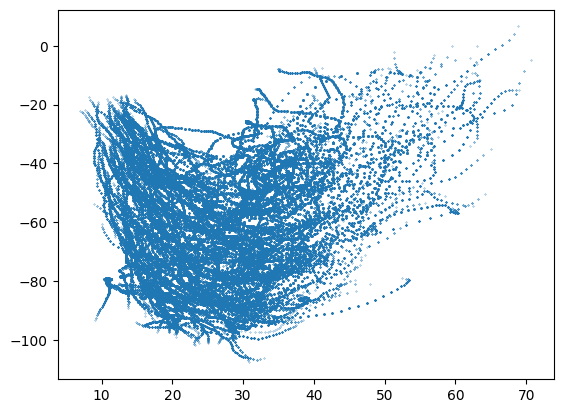

In [34]:
plt.plot(tensor_context_data_reshape[:,0], tensor_context_data_reshape[:,1], marker=".", linestyle='None', markersize=0.5)
print(np.max(tensor_context_data_reshape, axis=0), np.min(tensor_context_data_reshape, axis=0))

In [35]:
scaler = LinearScaler(target_min_vec=[-2,1], target_max_vec=[2,3])
# scaler = LinearScaler(target_min_vec=[-1,-1], target_max_vec=[1,1])
# scaler = MinMaxScaler()
trafo_data = scaler.fit_transform(tensor_context_data_reshape)

[2. 3.] [-2.  1.]


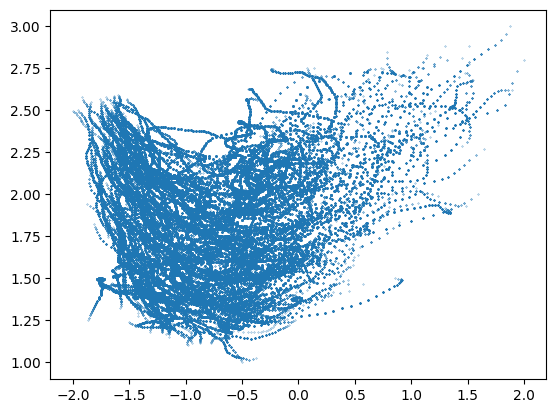

In [36]:
plt.plot(trafo_data[:,0], trafo_data[:,1], marker=".", linestyle='None', markersize=0.5)
print(np.max(trafo_data, axis=0), np.min(trafo_data, axis=0))

Looks good.

NOTE: StandardScaler also implements a global linear scaling to a domain defined via zero mean and unit variance.

### Train and compare kernel models

In [37]:
# scaler = StandardScaler()
scaler = LinearScaler()
# scaler = MinMaxScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

In [38]:
contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

In [39]:
for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (7765, 42, 2): 7765 contexts of length 42 with 2 features each
Test contexts have shape (1334, 42, 2): 1334 contexts of length 42 with 2 features each


### Train and compare kernel models

In [28]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

Length scale: 50.0


In [29]:
# model = Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi')
model = Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42)
# model = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)

In [36]:
from klearn_tcyclone.models_utils import predict_context_shift, predict_time_series

NOTE: Have to understand the context windows better. Is the last entry of a context window going in the prediction?

In [37]:
stop = 500
model, fit_time = timer(model.fit)(contexts['train'][:stop])

In [38]:
contexts['train'].shape, model.lookback_len

((8150, 42, 2), 41)

In [39]:
contexts["train"].lookforward(41).shape

(8150, 1, 2)

In [40]:
initial_context = contexts['train'][23]

In [41]:
ts = predict_time_series(model, initial_context, n_steps=13)

In [43]:
ts

array([[-0.64278317, -0.23437695],
       [-0.6396635 , -0.23525247],
       [-0.63526903, -0.24442711],
       [-0.6308357 , -0.25138102],
       [-0.62597281, -0.25889392],
       [-0.62082932, -0.26597601],
       [-0.61537311, -0.27277022],
       [-0.60962282, -0.27913124],
       [-0.6035819 , -0.28505706],
       [-0.59727222, -0.29055844],
       [-0.59072999, -0.29565667],
       [-0.58401796, -0.30036937],
       [-0.57718207, -0.30470636]])

NOTE: Checkout from kooplearn._src.operator_regression.dual import predict

This function can predict for several time steps but only outputs the last one. Predicting a given context for several timesteps leads probably to something different than predicting one time step ahead, building the new context by shifting to this, and compute the next time step prediction and so on. Could be interesting to compare these two things in terms of runtime and accuracy.

In [44]:
X_pred_test = model.predict(contexts['train'])
X_pred_test.shape, contexts['train'].shape

((8150, 1, 2), (8150, 42, 2))

In [45]:
X_pred_test = model.predict(contexts['test'])
X_pred_test.shape, contexts['test'].shape

((949, 1, 2), (949, 42, 2))

In [46]:
from klearn_tcyclone.models_utils import runner

In [47]:
# def runner(model, contexts, stop):
#     results = {}

#     # Model fitting
#     model, fit_time = timer(model.fit)(contexts['train'][:stop])

#     # One-step prediction
#     X_pred_train = model.predict(contexts['train'])
#     X_true_train = contexts['train'].lookforward(model.lookback_len)
#     X_pred_test = model.predict(contexts['test'])
#     X_true_test = contexts['test'].lookforward(model.lookback_len)

#     results["train_stop"] = stop
#     results["fit_time"] = fit_time
#     results["RMSE_onestep_train_error"] = np.sqrt(np.mean((X_pred_train - X_true_train)**2))
#     results["RMSE_onestep_test_error"] = np.sqrt(np.mean((X_pred_test - X_true_test)**2))

#     print(r'Fitting of model took {:.2f}s with train RMSE of {:.5f} and test RMSE of {:.5f}.'.format(results["fit_time"], results["RMSE_onestep_train_error"], results["RMSE_onestep_test_error"]))

#     return results

In [49]:
# train_stops = np.logspace(2.5, 2.9, 5).astype(int)
train_stops = np.logspace(2.5, 3.9, 5).astype(int)
train_stops

array([ 316,  707, 1584, 3548, 7943])

In [50]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

models = {
    # 'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
    'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
}

Length scale: 50.0


In [51]:
results = {}
for name in models.keys():
    results[name] = []
for ((name, model), stop) in product(models.items(), train_stops):
    print(f"\nModel: {name}", f'Training points: {stop}')
    results[name].append(runner(model, contexts, stop))


Model: Randomized-RRR Training points: 316
Fitting of model took 0.05s with train RMSE of 0.02860 and test RMSE of 0.02854.

Model: Randomized-RRR Training points: 707
Fitting of model took 0.09s with train RMSE of 0.02382 and test RMSE of 0.02288.

Model: Randomized-RRR Training points: 1584
Fitting of model took 0.28s with train RMSE of 0.02129 and test RMSE of 0.02056.

Model: Randomized-RRR Training points: 3548
Fitting of model took 1.81s with train RMSE of 0.01950 and test RMSE of 0.01841.

Model: Randomized-RRR Training points: 7943


The rank attribute has been updated to 10.
Consider decreasing the rank parameter.


Fitting of model took 9.31s with train RMSE of 0.01924 and test RMSE of 0.01806.

Model: Nystroem-RRR Training points: 316
Fitting of model took 0.15s with train RMSE of 0.05449 and test RMSE of 0.05136.

Model: Nystroem-RRR Training points: 707


Fitting of model took 0.23s with train RMSE of 0.04369 and test RMSE of 0.04114.

Model: Nystroem-RRR Training points: 1584


Fitting of model took 0.39s with train RMSE of 0.04195 and test RMSE of 0.03862.

Model: Nystroem-RRR Training points: 3548


The rank attribute has been updated to 9.
Consider decreasing the rank parameter.


Fitting of model took 0.28s with train RMSE of 0.04231 and test RMSE of 0.03877.

Model: Nystroem-RRR Training points: 7943


Fitting of model took 0.46s with train RMSE of 0.04103 and test RMSE of 0.03763.


In [52]:
timings = {name: np.array([res["fit_time"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_train_errors = {name: np.array([res["RMSE_onestep_train_error"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_test_errors = {name: np.array([res["RMSE_onestep_test_error"] for res in results[name]]) for name in models.keys()}
speedup_train = {name: timings["Randomized-RRR"]/timings[name] for name in models.keys()}

Average fitting time speed-up for Randomized-RRR: 1.00x
Average fitting time speed-up for Nystroem-RRR: 5.62x


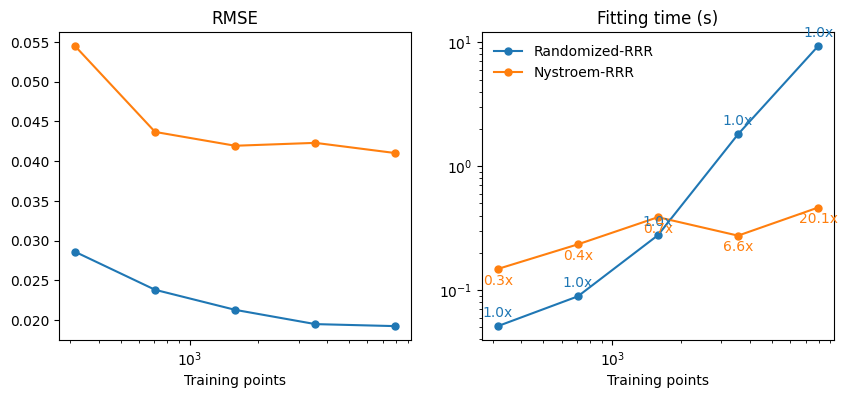

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, RMSE_onestep_train_errors[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup_train[name]):
        if (name == 'Randomized-RRR'):
            c = colors[0]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup_train[name]):.2f}x")



### ModelBenchmark class

The above functionality (and a bit more) is combined in the ModelBenchmark class.

In [54]:
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark

In [55]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)
context_length = 42
feature_list = ["lat", "lon"]
scaler = LinearScaler()


reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

models = {
    'RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi'),
    'Randomized-RRR': Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42),
    'Nystroem-RRR': NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42),
}

2024-09-01 09:28:15,385 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393
Length scale: 50.0


In [57]:
# train_stops = np.logspace(2.5, 2.9, 5).astype(int)
train_stops = np.logspace(2.5, 3.9, 5).astype(int)
train_stops

array([ 316,  707, 1584, 3548, 7943])

In [58]:
model_benchmarks = {
    name: ModelBenchmark(
        model,
        feature_list,
        tc_tracks_train,
        tc_tracks_test,
        scaler=scaler,
        context_length=context_length,
    )
    for name, model in models.items()
}

In [59]:
print([mb.get_info() for mb in model_benchmarks.values()])

Train contexts have shape (8038, 42, 2): 8038 contexts of length 42 with 2 features each.
Test contexts have shape (1061, 42, 2): 1061 contexts of length 42 with 2 features each.
Train contexts have shape (8038, 42, 2): 8038 contexts of length 42 with 2 features each.
Test contexts have shape (1061, 42, 2): 1061 contexts of length 42 with 2 features each.
Train contexts have shape (8038, 42, 2): 8038 contexts of length 42 with 2 features each.
Test contexts have shape (1061, 42, 2): 1061 contexts of length 42 with 2 features each.
[None, None, None]


In [60]:
results = {name: mb.train_model(train_stops) for name, mb in model_benchmarks.items()}


Model training: Training points: 316


Fitting of model took 0.26s with train RMSE of 0.02838 and test RMSE of 0.03475.

Model training: Training points: 707
Fitting of model took 0.10s with train RMSE of 0.02024 and test RMSE of 0.02621.

Model training: Training points: 1584


Fitting of model took 0.61s with train RMSE of 0.01943 and test RMSE of 0.02451.

Model training: Training points: 3548


Fitting of model took 3.12s with train RMSE of 0.01909 and test RMSE of 0.02460.

Model training: Training points: 7943


Fitting of model took 21.01s with train RMSE of 0.01892 and test RMSE of 0.02409.

Model training: Training points: 316
Fitting of model took 0.01s with train RMSE of 0.02838 and test RMSE of 0.03475.

Model training: Training points: 707
Fitting of model took 0.05s with train RMSE of 0.02024 and test RMSE of 0.02621.

Model training: Training points: 1584
Fitting of model took 0.30s with train RMSE of 0.01943 and test RMSE of 0.02451.

Model training: Training points: 3548
Fitting of model took 1.44s with train RMSE of 0.01909 and test RMSE of 0.02461.

Model training: Training points: 7943


The rank attribute has been updated to 9.
Consider decreasing the rank parameter.


Fitting of model took 8.45s with train RMSE of 0.01892 and test RMSE of 0.02409.

Model training: Training points: 316
Fitting of model took 0.15s with train RMSE of 0.05475 and test RMSE of 0.06827.

Model training: Training points: 707


Fitting of model took 0.29s with train RMSE of 0.04213 and test RMSE of 0.05563.

Model training: Training points: 1584


Fitting of model took 0.30s with train RMSE of 0.03995 and test RMSE of 0.05126.

Model training: Training points: 3548


Fitting of model took 0.34s with train RMSE of 0.04093 and test RMSE of 0.05261.

Model training: Training points: 7943


The rank attribute has been updated to 8.
Consider decreasing the rank parameter.


Fitting of model took 0.50s with train RMSE of 0.03890 and test RMSE of 0.05002.


In [61]:
timings = {name: np.array([res["fit_time"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_train_errors = {name: np.array([res["RMSE_onestep_train_error"] for res in results[name]]) for name in models.keys()}
RMSE_onestep_test_errors = {name: np.array([res["RMSE_onestep_test_error"] for res in results[name]]) for name in models.keys()}
speedup_train = {name: timings["RRR"]/timings[name] for name in models.keys()}
# speedup_train = {name: timings["Randomized-RRR"]/timings[name] for name in models.keys()}

Average fitting time speed-up for RRR: 1.00x
Average fitting time speed-up for Randomized-RRR: 6.47x
Average fitting time speed-up for Nystroem-RRR: 11.09x


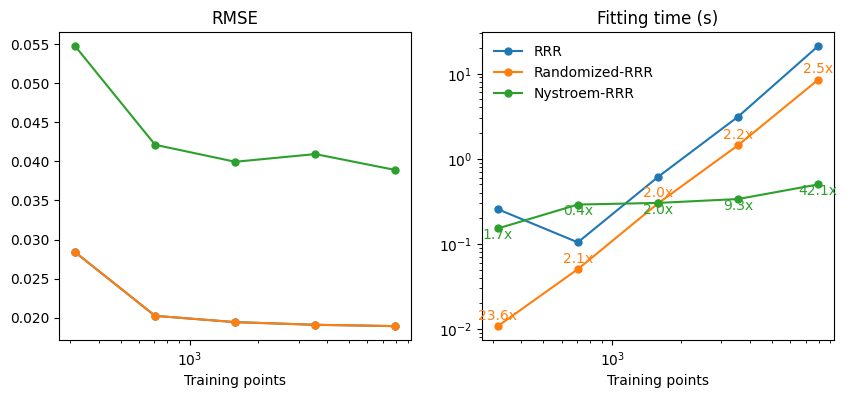

In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
for name in models.keys():
    axes[0].plot(train_stops, RMSE_onestep_train_errors[name],'.-', label=name, markersize=10)
    axes[1].plot(train_stops, timings[name],'.-', label=name, markersize=10)

colors = []
for line in axes[0].get_lines():
    colors.append(line.get_color())

axes[0].set_title('RMSE')
axes[1].set_title('Fitting time (s)')
axes[1].legend(frameon = False, loc = 'upper left')
axes[1].set_yscale('log')

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlabel('Training points')

ax = axes[1]
for name in models.keys():
    for i, el in enumerate(speedup_train[name]):
        if (name == 'Randomized-RRR'):
            c = colors[1]
            ax.text(train_stops[i], timings[name][i]*1.2, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        elif (name == 'Nystroem-RRR'):
            c = colors[2]
            ax.text(train_stops[i], timings[name][i]*0.75, f'{el:.1f}x', fontsize=10, color = c, ha='center')
        else:
            pass
    print(f"Average fitting time speed-up for {name}: {np.mean(speedup_train[name]):.2f}x")

